In [1]:
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob 

import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import glob
import json
from random import sample
import sklearn
import re
import string
import warnings
from bs4 import BeautifulSoup
import gensim
from gensim.models.phrases import Phrases
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from analysis_func.text_preproc import preproc_text
from analysis_func.old_text_preproc import preprocess_e2e, preprocess_pre_tokenizing
from analysis_func.topic_preproc import prepare_corp
from analysis_func.topic_model import topicmodel
from analysis_func.saveload_topicmodels import save_modelanddata, load_modelanddata
import datetime
import os
import time
import sys
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from analysis_func.text_preproc import preproc_text
from analysis_func.topic_preproc import prepare_corp
from analysis_func.topic_model import topicmodel
from analysis_func.saveload_topicmodels import save_modelanddata, load_modelanddata


from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
climate_data = pd.read_csv("/data/shruti/conspirecovery/reddit/initial/smallConsp/climate_data.csv", header=0)
climate_data.head()

,Unnamed: 0,author,subreddit,created_utc,score,id,body,author_flair_text,type,clean_text,cleaner_text
0,316,ThrombBone,climateskeptics,1545115904,1.0,ec14vna,Your models are not proof and your revisionist...,NaN,comment,your models are not proof and your revisionist...,models proof revisionist history ethical
1,333,thesnarkisaboojum,climateskeptics,1365866358,4.0,c9eewk3,Everything was pretty happy during the medieva...,NaN,comment,everything was pretty happy during the medieva...,pretty happy medieval warm period edit len...
2,482,pr-mth-s,climateskeptics,1474383908,10.0,53ns5l,Most of Ben &amp; Jerry's 300K twitter followe...,NaN,submission,most of ben jerry s 300k twitter followers w...,ben jerry 300k twitter followers flavors lo...
3,510,bugsbunny4pres,climateskeptics,1541689831,10.0,9vas5k,Climate Genocide Coming,NaN,submission,climate genocide coming,climate genocide coming
4,662,barttali,climateskeptics,1501193648,4.0,dktddwn,Did you notice that NASA said **AVERAGE SEPTEM...,NaN,comment,did you notice that nasa said average septembe...,notice nasa average september extent word s...


In [3]:
climate_data['subreddit'].unique()

array(['climateskeptics', 'Globalwarmingisfake', 'comment',
       'climateconspiratard', nan], dtype=object)

In [9]:
climate_data = climate_data.dropna(subset=['subreddit'])

In [10]:
climate_data = climate_data.loc[climate_data['subreddit']!='comment']
len(climate_data)

298014

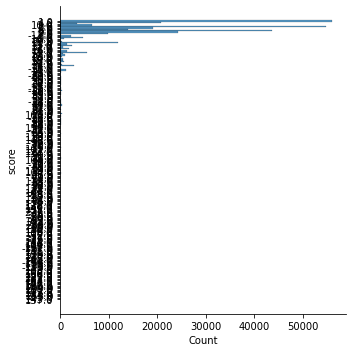

In [11]:
sns.displot(climate_data, y="score")

In [13]:
print(Counter(climate_data['score'].tolist()))

Counter({'1.0': 56011, '2.0': 54682, '3.0': 43576, '0.0': 24347, '4.0': 20729, '5.0': 19127, '6.0': 13882, '-1.0': 11828, '7.0': 9736, '8.0': 6447, '-2.0': 5544, '9.0': 4677, '10.0': 3363, '-3.0': 2791, '11.0': 2470, '-4.0': 2155, '12.0': 1800, '13.0': 1431, '-5.0': 1352, '14.0': 1104, '15.0': 935, '-6.0': 849, '16.0': 773, '17.0': 650, '-7.0': 541, '18.0': 540, '19.0': 493, '21.0': 389, '20.0': 388, '-8.0': 377, '22.0': 355, '23.0': 303, '24.0': 286, '26.0': 229, '25.0': 227, '-9.0': 226, '27.0': 192, '28.0': 163, '29.0': 159, '-10.0': 148, '30.0': 142, '31.0': 127, '33.0': 119, '-11.0': 117, '35.0': 117, '34.0': 104, '32.0': 102, '37.0': 96, '38.0': 88, '36.0': 87, '-12.0': 86, '39.0': 69, '41.0': 62, '44.0': 61, '-13.0': 60, '40.0': 53, '42.0': 50, '43.0': 48, '50.0': 47, '48.0': 44, '-15.0': 44, '-14.0': 40, '45.0': 40, '47.0': 39, '46.0': 37, '51.0': 36, '53.0': 36, '49.0': 34, '52.0': 30, '-16.0': 28, '55.0': 27, '57.0': 26, '54.0': 25, '58.0': 24, '56.0': 23, '62.0': 21, '63.0':

In [3]:
#pd.set_option("max_colwidth", -1)
climate_data[['body','cleaner_text']].sample(10)

,body,cleaner_text
35268,An Updated Review about Carbon Dioxide and Cli...,updated review carbon dioxide climate change s...
92437,"Sorry junior... the ""fail"" buzzer is on you.\n...",junior fail buzzer don clue ph
274277,"Australia’s Heatwave: Just Weather, Not Climat...",australia’s heatwave weather climate change
235835,So will you take my bet or do you lack the cou...,bet lack courage convictions previous post qu...
213093,You just aren't getting this. When you destroy...,destroy credibility don goodwill single thin...
208136,"Sorry, I meant models in the last paragraph. T...",meant models paragraph crux argument spenc...
103733,Counters wrote this blanket statement howler:\...,counters wrote blanket statement howler impr...
16865,Ask the Germans and South Australians. Their e...,germans south australians electric utility bi...
193205,"A) use np links, what you did could be conside...",np links considered vote brigading obvious ...
291630,Climate Change Is Contributing To Globally Sur...,climate change contributing globally surging d...


In [4]:
tuples = pd.read_csv("../lite_data/climate_tuples.csv", header=0)
tuples.head()
vaxAuthors = list(set(tuples['author'].tolist()))
dlist = []
fnames = glob.glob("/data/shruti/conspirecovery/reddit/initial/content/authorContent*.gz")
for f in fnames:
    print(f)
    temp_F = pd.read_csv(f, header=0)
    temp_F = temp_F.loc[temp_F['author'].isin(vaxAuthors)]
    dlist.append(temp_F)

data = pd.concat(dlist)
data.head()

/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000000.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000001.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000002.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000003.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000004.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000005.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000006.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000007.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000008.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000009.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000010.gz
/data/shruti/conspirecovery/reddit/initial/content/authorContent000000000011.gz
/data/shruti/conspirecovery/reddit/initi

,author,subreddit,created_utc,score,id,body,author_flair_text,type
3,jeepdave,todayilearned,1565252595,1.0,ewav3lm,Doesn't make the courts right.,NaN,comment
4,kriegson,progun,1539875448,5.0,e803e5h,"They always try to deflect, dismiss and de-per...",NaN,comment
6,flowirin,pics,1485329315,1.0,dcvnbrj,"yep, waaay less here",NaN,comment
7,nakedapedude,newzealand,1483421680,6.0,dbxn157,"Swap his vegemite for marmite, that's pretty m...",NaN,comment
8,ranman1124,MapPorn,1468941216,2.0,d5i7vpc,No.,NaN,comment


In [5]:
antivax = ["vaccineskeptics","VaccinesCause","HealthConspiracy", "VaxTalk", "VaccineIngredients"]
climateskeptic = ["climateskeptics","greenskeptics","climatechangebullshit","climatehoax","Globalwarmingisfake","climateconspiratard"]
chemprints = ["CHEMPRINTS","Chemtrail","chemtrails","chemtrailpilots"]
flatearth = ["notaglobe","theworldisflat","flatearth", "Flat_Earth", "Flatearther"]
proclimate = ["ClimateCrisis", "CarbonCapture", "Climate_Discussion", "Climate", "ClimateActionPlan", "ClimateOffensive", "climatechange"]
conspiracy = ["conspriacy", "The_Donald"]
politics = ["Libertarian", "Conservative"]

In [6]:
def subredditgroup(subreddit):
    if subreddit in proclimate:
        return "proclimate"
    if subreddit in climateskeptic:
        return "climateskeptic"
    if subreddit in conspiracy:
        return "conspiracysub"
    if subreddit in politics:
        return "politicssub"
    
    return subreddit

In [7]:
data['g_sub'] = data["subreddit"].parallel_apply(lambda x: subredditgroup(x))

In [8]:
subgroups = ["proclimate", "climateskeptic", "conspiracysub", "politicssub"]

In [9]:
nonclimate_data = data.loc[data['g_sub'].isin(subgroups)]

In [10]:
swords = []
with open("../lite_data/stopwords.txt", "r") as rfile:
    for line in rfile:
        swords.append(line.strip("\n"))

In [11]:
len(nonclimate_data)

1475681

In [12]:
nonclimate_data = nonclimate_data.dropna(subset=['body'])
len(nonclimate_data)

1475674

In [13]:
terms = ["ozone layer scam", "climate doomsday", "cult of climatology", "alarmist", 
         "carbon tax scam", "greenies", "virtue-signal", "virtue signal", "harmless gas", "climate politics", 
         "global warming scam", "climate alarmist", "warmist", "climate geniuses", "climate change alarmism", 
         "global warming 'problem'", "climategate", "climate terrorist", "climate hoax", "climatehoax", 
         "cultishly", "gloom narrative", "warming hoax", "climate alarmism"]

def is_present(text):
    try:
        for t in terms:
            if t in text.lower():
                return 1
    except:
        fakevar=1
        
nonclimate_data['denials'] = nonclimate_data['body'].parallel_apply(lambda x: is_present(x))
nonclimate_data.loc[nonclimate_data['denials']==1]

,author,subreddit,created_utc,score,id,body,author_flair_text,type,g_sub,denials
1410,gentlyfailing,climateskeptics,1482311670,1.0,dbgineq,\n\nI think most people know that its not abou...,NaN,comment,climateskeptic,1.0
4072,502323,climateskeptics,1416509391,5.0,cm86hqt,CO2 dangerous? I wish climate alarmists would...,NaN,comment,climateskeptic,1.0
4880,AlyssaMoore,climateskeptics,1297790727,4.0,c1gw4gh,&gt;Politics has nothing at all to do with the...,NaN,comment,climateskeptic,1.0
5066,ActuallyNot,climateskeptics,1399729825,0.0,chef54y,&gt; The mistake alarmists make again and agai...,NaN,comment,climateskeptic,1.0
6818,ultimis,Conservative,1575787989,2.0,fa2xh0f,How about censuring Schiff for violating the C...,Constitutionalist,comment,politicssub,1.0
...,...,...,...,...,...,...,...,...,...,...
2166250,logicalprogressive,climateskeptics,1450566432,3.0,cy4wyt1,Looks like hang-nail doesn't think for himself...,NaN,comment,climateskeptic,1.0
2168758,Maxi720736,climateskeptics,1562409107,3.0,et21vhy,\n\nClimategate exposed !!\n\n\n\n\n\n\nBy Chr...,NaN,comment,climateskeptic,1.0
2169435,Kim147,climateskeptics,1571535204,2.0,f4cxgkt,"What do you mean by ""denialism""? The climate i...",NaN,comment,climateskeptic,1.0
2169485,logicalprogressive,climateskeptics,1555550368,3.0,el5ils1,You're on a roll today. Some facts for your ed...,NaN,comment,climateskeptic,1.0


In [14]:
nonclimate_data.loc[nonclimate_data['denials']==1].sample(5)

,author,subreddit,created_utc,score,id,body,author_flair_text,type,g_sub,denials
755694,logicalprogressive,climateskeptics,1545970732,2.0,ecpgiqq,Thank you for telling us what a skeptic should...,NaN,comment,climateskeptic,1.0
1445309,logicalprogressive,climateskeptics,1442808585,2.0,cv8piqs,Take your Alarmist ad hominem attacks where th...,NaN,comment,climateskeptic,1.0
210133,kriegson,climateskeptics,1437229869,2.0,ct7ov71,"Yeah, CA ha a number of problems however manag...",NaN,comment,climateskeptic,1.0
1291138,ActuallyNot,climateskeptics,1384494419,-8.0,cdes67h,&gt; To bad you alarmists can't draw one causa...,NaN,comment,climateskeptic,1.0
544883,Figmania,climateskeptics,1533417293,3.0,e3m2uwd,When a chemical mass balance is performed by u...,NaN,comment,climateskeptic,1.0


In [15]:
cd = nonclimate_data.loc[nonclimate_data['denials']==1]
print(Counter(cd['subreddit'].tolist()))

Counter({'climateskeptics': 20378, 'The_Donald': 1051, 'climatechange': 728, 'Conservative': 683, 'Libertarian': 618, 'ClimateOffensive': 14, 'ClimateActionPlan': 6, 'Globalwarmingisfake': 3, 'ClimateCrisis': 2})


In [16]:
print(len(set(cd['author'].tolist())))

1516


In [17]:
print(Counter(cd.loc[cd['g_sub']=='climateskeptic']['author'].tolist()))

Counter({'logicalprogressive': 3378, 'AlyssaMoore': 1113, 'climate_control': 792, 'Will_Power': 682, 'pr-mth-s': 589, 'bugsbunny4pres': 413, 'Kim147': 413, 'moirende': 392, 'barttali': 321, 'deck_hand': 318, 'publius_lxxii': 277, 'Kelly_jernigan': 270, 'counters': 238, 'LWRellim': 226, 'kriegson': 218, 'bean-a': 214, 'technologyisnatural': 214, 'e-socrates': 210, 'v_maet': 189, 'FormerlyTurnipHugger': 186, 'ozric101': 185, 'butch123': 179, 'JRugman': 176, 'TheFerretman': 173, 'romark1965': 173, 'FireFoxG': 168, 'ActuallyNot': 161, '3DogNapt': 160, 'OortCloud': 117, 'Florinator': 108, 'pnewell': 104, 'hammiesink': 98, 'Seele': 98, 'Nurizeko': 97, 'WhiskeyStr8Up': 90, 'SftwEngr': 90, 'thingsbreak': 83, 'ThrombBone': 81, 'tttt0tttt': 79, 'DoktorOmni': 78, 'mylankovic': 76, 'donaldosaurus': 75, 'propshaft': 73, 'ShieldAre': 68, 'Feldheld': 68, 'claircontlar': 67, 'DonnieS1': 67, 'luckinator': 63, 'etzpcm': 58, 'BackwardMelon': 58, 'Fiilu': 58, 'UnknownXV': 54, 'farfiman': 53, 'RabidRaccoon

In [22]:
len(climate_data)

298025

In [23]:
nonclim_authors = list(set(cd['author'].tolist()))

In [24]:
tuples = pd.read_csv("../lite_data/climate_tuples.csv", header=0)
tuples.head()

,Unnamed: 0,Unnamed: 0.1,author,created_utc,score,subreddit,type,g_subs,rank,bin
0,0,0,chabanais,1374889166,0.0,Conservative,comment,Conservative,87375.0,8.0
1,3,3,Patriot4evr,1566312474,6.0,Justfuckmyshitup,comment,Justfuckmyshitup,2518.0,5.0
2,9,9,Fake_William_Shatner,1533736128,1.0,worldnews,comment,worldnews,20017.0,6.0
3,10,10,hybrid_remix,1560872065,1.0,heroesofthestorm,comment,heroesofthestorm,991.0,3.0
4,11,11,kirkisartist,1531524275,0.0,omise_go,comment,omise_go,2953.0,2.0


In [25]:
a1 = list(set(tuples['author'].tolist()))
a2 = nonclim_authors

print(len(a1), len(a2), len(set(a1).intersection(set(a2))))

3251 1516 1516


In [26]:
c_tuples = tuples.loc[tuples['author'].isin(a2)]
print(Counter(c_tuples['g_subs'].tolist()))

Counter({'politics': 545833, 'The_Donald': 445263, 'AskReddit': 387687, 'Conservative': 277595, 'climateskeptic': 277448, 'worldnews': 274768, 'Libertarian': 270930, 'news': 158248, 'conspiracy': 144256, 'todayilearned': 115387, 'pics': 109570, 'funny': 93405, 'Right_Wing_Politics': 90984, 'science': 90229, 'technology': 71157, 'reddit.com': 70837, 'WTF': 66550, 'canada': 63514, 'videos': 60577, 'skeptic': 58809, 'worldpolitics': 56255, 'environment': 55722, 'metacanada': 54437, 'Anarcho_Capitalism': 54055, 'movies': 52698, 'nfl': 52495, 'atheism': 52341, 'POLITIC': 50498, 'AdviceAnimals': 50190, 'AustralianPolitics': 47745, 'KotakuInAction': 47337, 'Economics': 47035, 'neoliberal': 43982, 'australia': 40675, 'ukpolitics': 40272, 'DebateReligion': 39402, 'PoliticalDiscussion': 39099, 'collapse': 38572, 'Christianity': 37771, 'gaming': 37488, 'CringeAnarchy': 35410, 'Bitcoin': 34820, 'ShitPoliticsSays': 34046, 'Futurology': 33700, 'unitedkingdom': 33361, 'MensRights': 32678, 'Conservati

In [27]:
c_tuples['g_subs'] = c_tuples['g_subs'].parallel_apply(lambda x: x if x=='climateskeptic' else 'nonclim')

<ipython-input-27-386c1f9edabd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_tuples['g_subs'] = c_tuples['g_subs'].parallel_apply(lambda x: x if x=='climateskeptic' else 'nonclim')


In [28]:
c_tuples.sample(5)

,Unnamed: 0,Unnamed: 0.1,author,created_utc,score,subreddit,type,g_subs,rank,bin
1130972,2477181,2478870,ultimaregem,1548429129,1.0,Right_Wing_Politics,submission,nonclim,35908.0,4.0
13590747,29903606,2245440,Emwonk2,1542377959,26.0,AskReddit,comment,nonclim,2358.0,9.0
13674046,30086731,2429087,qp0n,1461347972,1.0,Showerthoughts,comment,nonclim,24806.0,6.0
11953986,26294693,7861844,fantoman,1423160778,1.0,psx,comment,nonclim,6261.0,7.0
9358267,20581109,2135337,MuddyFilter,1543685483,-4.0,ChapoTrapHouse,comment,nonclim,10495.0,8.0


In [29]:
ctup_contribs = c_tuples.groupby(['author','g_subs','bin']).size().reset_index()
ctup_contribs.head()

,author,g_subs,bin,0
0,--_-_o_-_--,climateskeptic,3.0,90
1,--_-_o_-_--,nonclim,1.0,1567
2,--_-_o_-_--,nonclim,2.0,1567
3,--_-_o_-_--,nonclim,3.0,1477
4,--_-_o_-_--,nonclim,4.0,1568


In [30]:
ctup_contribs.sort_values(by=['author','bin'])

,author,g_subs,bin,0
1,--_-_o_-_--,nonclim,1.0,1567
2,--_-_o_-_--,nonclim,2.0,1567
0,--_-_o_-_--,climateskeptic,3.0,90
3,--_-_o_-_--,nonclim,3.0,1477
4,--_-_o_-_--,nonclim,4.0,1568
...,...,...,...,...
22259,zuckernburg,nonclim,6.0,612
22260,zuckernburg,nonclim,7.0,612
22261,zuckernburg,nonclim,8.0,612
22262,zuckernburg,nonclim,9.0,612


In [33]:
b1 = pd.pivot_table(ctup_contribs, values=0, index=['author', 'bin'], columns='g_subs').reset_index()
b1.head()

g_subs,author,bin,climateskeptic,nonclim
0,--_-_o_-_--,1.0,NaN,1567.0
1,--_-_o_-_--,2.0,NaN,1567.0
2,--_-_o_-_--,3.0,90.0,1477.0
3,--_-_o_-_--,4.0,NaN,1568.0
4,--_-_o_-_--,5.0,NaN,1567.0


In [35]:
print(len(b1), len(b1.dropna(subset=['nonclim'])))

15160 14872


In [36]:
b1['climateskeptic'] = b1['climateskeptic'].fillna(0)
b1['nonclim'] = b1['nonclim'].fillna(0)

In [38]:
b1.tail(50)

g_subs,author,bin,climateskeptic,nonclim
15110,yself,1.0,0.0,240.0
15111,yself,2.0,0.0,240.0
15112,yself,3.0,0.0,240.0
15113,yself,4.0,0.0,240.0
15114,yself,5.0,0.0,241.0
15115,yself,6.0,0.0,240.0
15116,yself,7.0,0.0,240.0
15117,yself,8.0,0.0,240.0
15118,yself,9.0,0.0,240.0
15119,yself,10.0,10.0,231.0


In [39]:
b1['total_contrib'] = b1['climateskeptic'] + b1['nonclim']
b1.head()

g_subs,author,bin,climateskeptic,nonclim,total_contrib
0,--_-_o_-_--,1.0,0.0,1567.0,1567.0
1,--_-_o_-_--,2.0,0.0,1567.0,1567.0
2,--_-_o_-_--,3.0,90.0,1477.0,1567.0
3,--_-_o_-_--,4.0,0.0,1568.0,1568.0
4,--_-_o_-_--,5.0,0.0,1567.0,1567.0


In [40]:
b1['percent_climden'] = b1['climateskeptic']/b1['total_contrib']
b1.head()

g_subs,author,bin,climateskeptic,nonclim,total_contrib,percent_climden
0,--_-_o_-_--,1.0,0.0,1567.0,1567.0,0.000000
1,--_-_o_-_--,2.0,0.0,1567.0,1567.0,0.000000
2,--_-_o_-_--,3.0,90.0,1477.0,1567.0,0.057435
3,--_-_o_-_--,4.0,0.0,1568.0,1568.0,0.000000
4,--_-_o_-_--,5.0,0.0,1567.0,1567.0,0.000000


In [42]:
b2 = pd.pivot_table(b1, values='percent_climden', index='author', columns='bin').reset_index()
b2.head(50)

bin,author,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,--_-_o_-_--,0.000000,0.000000,0.057435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-Dode,0.006667,0.006667,0.046667,0.026490,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-Kolya-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.437500,0.000000,0.000000
3,-Natsoc-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104252,0.000000
4,-rabid-,0.000000,0.000973,0.002921,0.000000,0.001946,0.000974,0.004864,0.005842,0.007782,0.000000
5,01314150,0.000000,0.000000,0.000000,0.001553,0.000000,0.003106,0.007764,0.000000,0.013975,0.007764
6,02116663ag,0.000000,0.000000,0.011905,0.000000,0.094118,0.000000,0.130952,0.095238,0.190476,0.152941
7,0ldBasterd,0.140351,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0phantom0,0.000000,0.026316,0.054054,0.105263,0.342105,0.540541,0.368421,0.081081,0.000000,0.000000
9,0theus,0.077922,0.116883,0.077922,0.012987,0.000000,0.000000,0.000000,0.012987,0.000000,0.000000


In [44]:
#!pip3 install tslearn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 875 kB 24.0 MB/s            
     |████████████████████████████████| 3.4 MB 74.9 MB/s            
     |████████████████████████████████| 1.9 MB 62.4 MB/s            
     |████████████████████████████████| 34.5 MB 67.4 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [45]:
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from collections import Counter, defaultdict
import numpy as np

/home/phadke/.local/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [46]:
def get_tslearn_silhouette(data, precomp_mat=None, min_cluster=2, max_cluster=15, metric= 'dtw', n_jobs=55):
    '''
        data: should be matrix of n_samples vs. n_features
        min_cluster: minimum number of clusters for calculating silhouette
        max_cluster: maximum number of clusters for calculating silhouette
        metric: distance metric for clustering, euclidean is the fastest
        n_jobs: for troop
        returns dataframe containing n_cluster and silhouette values
    '''
    sil_values = []
    silframe = pd.DataFrame(columns=['n', 'silhouette_Score'])

    for i in range(min_cluster, max_cluster+1):
        km = TimeSeriesKMeans(n_clusters=i, metric='dtw', n_jobs=n_jobs)
        labels = km.fit_predict(data)
        if metric == 'precomputed':
            s_s = silhouette_score(precomp_mat, labels, metric=metric, n_jobs=n_jobs)
        else:
            s_s = silhouette_score(data, labels, metric=metric, n_jobs=n_jobs)
        print(i, s_s)
        silframe = silframe.append({'n':i,'silhouette_Score':s_s }, ignore_index=True)
        silframe.to_csv("../lite_data/dtw_silhouette.csv")
        sil_values.append(s_s)

    
    #silframe['n'] =range(min_cluster, max_cluster+1)
    #silframe['silhouette_Score'] = sil_values

    return sil_values


In [47]:
bincols = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
silvals = get_tslearn_silhouette(np.array(b2[bincols].values), n_jobs=127)

2 0.7427256229572919
3 0.6586368963197259
4 0.6677767994811157
5 0.5696890037099199
6 0.5234957640655715
7 0.5198141477176182
8 0.48989417883821185
9 0.44766216901376227
10 0.49341123901921574
11 0.4537851911507563
12 0.38675242315379416
13 0.3533166199215834
14 0.3428843147698396
15 0.3677106796470675


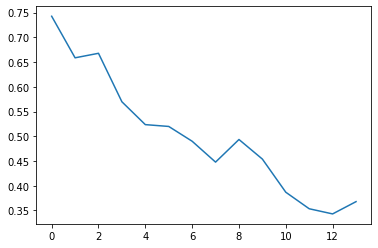

In [48]:
plt.plot(silvals)

In [49]:
def get_tslearn_clusters(data, n_clusters=4, metric= 'euclidean', n_jobs=None):
    '''
        data: should be matrix of n_samples vs. n_features
        n_clusters: number of desired clusters
        metric: distance metric for clustering, euclidean is the fastest
        n_jobs: for troop
        returns list of cluster assignments sized n_samples
    '''    
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, n_jobs=n_jobs)
    ts_cluster_labels = km.fit_predict(data)
    ts_cluster_centers = km.cluster_centers_

    print("Number of items in each cluster: ", Counter(ts_cluster_labels))
    return ts_cluster_labels, ts_cluster_centers


In [53]:
cluster_labels, cluster_centers = get_tslearn_clusters(np.array(b2[bincols].values), n_jobs=127, n_clusters=6, metric='dtw')

Number of items in each cluster:  Counter({4: 1071, 0: 182, 2: 108, 3: 72, 5: 45, 1: 38})


In [54]:
b2['clusers'] = cluster_labels

In [60]:
b2.loc[b2['clusers']==0]

bin,author,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,clusers
8,0phantom0,0.000000,0.026316,0.054054,0.105263,0.342105,0.540541,0.368421,0.081081,0.000000,0.000000,0
12,1DieselDave,0.044444,0.200000,0.133333,0.152174,0.333333,0.377778,0.173913,0.311111,0.288889,0.021739,0
26,672-EVIL,0.115044,0.105263,0.368421,0.043860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
33,ABlindOrphan,0.000000,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
49,Aljap,0.076923,0.000000,0.384615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1481,vovodiva,0.173913,0.666667,0.173913,0.375000,0.250000,0.173913,0.083333,0.130435,0.166667,0.208333,0
1492,windchaser__,0.333333,0.025000,0.075000,0.175000,0.150000,0.512821,0.500000,0.475000,0.075000,0.000000,0
1503,xgunterx,0.083333,0.360656,0.098361,0.114754,0.065574,0.116667,0.016393,0.032787,0.016393,0.000000,0
1506,xray606,0.360685,0.624324,0.190991,0.214414,0.267568,0.236036,0.003604,0.002703,0.000000,0.000000,0


In [18]:
# def remove_stops(text):
#     new_text = " ".join([t for t in text.split(" ") if t not in swords and not t.isdecimal()])
#     return new_text


# def text_proprocc_stop(text):
#     ctext = preprocess_e2e(text)
#     stext = remove_stops(ctext)
#     if len(stext) > 5:
#         return stext
    
    
# nonclimate_data['cleaner_text'] = nonclimate_data['body'].parallel_apply(lambda x: text_proprocc_stop(x))

# climate_data = climate_data.dropna(subset=['body'])
# climate_data['cleaner_text'] = climate_data['body'].parallel_apply(lambda x: text_proprocc_stop(x))

In [19]:
# nonclimate_data.sample(5)

In [20]:
# climate_data = climate_data.dropna(subset=['cleaner_text'])

In [21]:
# nonclimate_data = nonclimate_data.dropna(subset=['cleaner_text'])